In [1]:
# http://pycbc.org/pycbc/latest/html/waveform.html

import sys
!{sys.executable} -m pip install lalsuite pycbc

In [2]:
from pycbc.waveform import get_td_waveform
import pylab

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


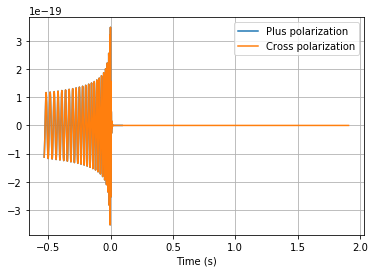

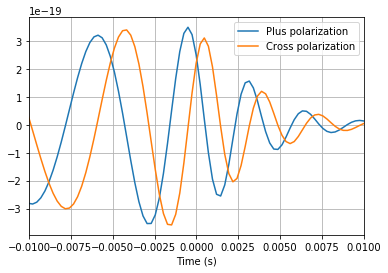

In [3]:
#output plus and cross polarization of gravitational waves
#????? confused : As viewed from the line of sight at a given source inclination (assumed face-on if not provided)
#The approximant "SEOBNRv4_opt" useful for inspiraling and merging, (with possibility of aligned spin)
hp,hc=get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=10, #solar mass
                     mass2=40,
                     delta_t=1.0/4096, #??????????? unit? why?
                     f_lower=30)  #???????????what is this
# output is Time Series obj


#plot (Notice, merge instant labeled as 0s)
pylab.plot(hp.sample_times, hp, label="Plus polarization") #sample_times, an attribute of Time series obj gives total time interal of time series
hp.resize(10000)
pylab.plot(hp.sample_times, hp, label="Cross polarization")
pylab.xlabel("Time (s)")
pylab.legend()
pylab.grid()
pylab.show()

#zoom in for merger phase
pylab.plot(hp.sample_times, hp, label="Plus polarization") #sample_times, an attribute of Time series obj
pylab.plot(hc.sample_times, hc, label="Cross polarization")
pylab.xlabel("Time (s)")
pylab.xlim(-0.01,0.01) #seem like template only from -2.0 to 0.0
pylab.legend()
pylab.grid()
pylab.show()
# Here polarization only differ by phases, the case when orbiral plane doesn't precess

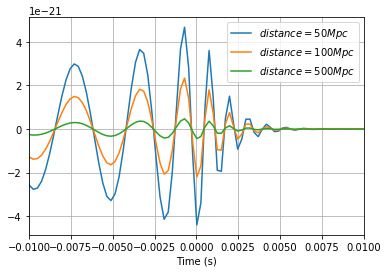

In [4]:
# change distance
# ?????no redshift effects so distance proportional to amplitude 
# unit: megaparsec

for d in [50, 100, 500]:
    hp,hc=get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=10, #solar mass
                     mass2=10,
                     delta_t=1.0/4096, #whyy????
                     f_lower=30,
                     distance=d)
    pylab.plot(hp.sample_times, hp, label='$distance=%sMpc$'%d)
pylab.xlabel("Time (s)")
pylab.xlim(-0.01,0.01)
pylab.legend()
pylab.grid()
pylab.show()

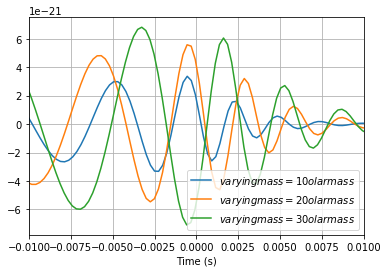

In [15]:
# change mass
# ?????no redshift effects so distance proportional to amplitude 
# unit: megaparsec

for m in [10, 20, 30]:
    hp,hc=get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m, #solar mass
                     mass2=30,
                     delta_t=1.0/4096, #whyy????
                     f_lower=30,
                     distance=100)
    pylab.plot(hp.sample_times, hp, label='$varyingmass=%solar mass$'%m)
pylab.xlabel("Time (s)")
pylab.xlim(-0.01,0.01)
pylab.legend()
pylab.grid()
pylab.show()

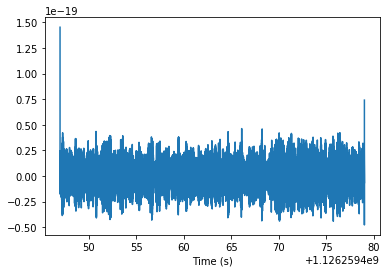

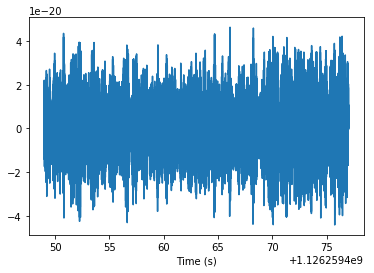

In [5]:
# Look for template in data 
# using matched filtering (optimal when knowing what signal to look for and gaussian noise)

#prepare data
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger=Merger("GW150914")

strain=merger.strain("H1") #data from Hanford detector, A TimeSeries obj

# remove low freq data and downsize to 2048HZ, but??????????????why
strain=resample_to_delta_t(highpass(strain, 15.0),1.0/2048)  #highpass: remove freq lower than 15hz

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

#Notice it is necessary to trim the ends due to the filtering processes ????????????? 
# important for all filtering

#remove 2 seconds from beginning and from end
conditioned=strain.crop(2,2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [6]:
#PSD stands for the Power Spectral Density of a signal.
# we need to weight the frequency component of data by noise amplitude (equivalent to filter data with time series 1/PSD) 
# ? we only take 4 seconds, first, how do we know the 4 seconds doesn't contain signal, second is 4 seconds enough for capturing detector behavior?
from pycbc.psd import interpolate, inverse_spectrum_truncation 
#estimate psd, get 4 seconds
psd=conditioned.psd(4)
#now need to interpolate it to match data, limit the filter length of 1 / PSD, then use it to filter
psd = interpolate(psd, conditioned.delta_f)
#1/PSD will now act as a filter with an effective length of 4 seconds
psd=inverse_spectrum_truncation(psd,4*conditioned.sample_rate,
                               low_frequency_cutoff=15)


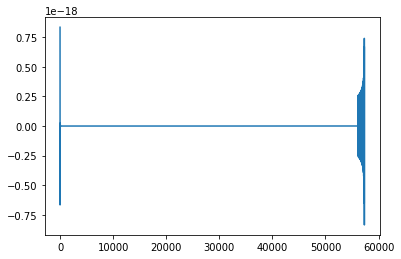

In [7]:
#NOW PREPARE SIGNAL MODEL (BEFORE WAS PREPARING DATA)
# Assuming we know the mass (when we don't do a grid.)
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.show()


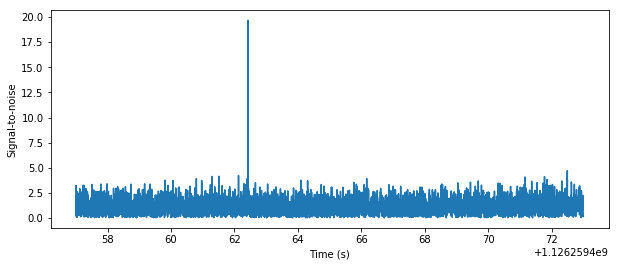

We found a signal at 1126259462.4248047s with SNR 19.678977177701526


In [8]:
#Signal to noise ratio
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length 
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))